## Agentic Memory and Streaming
### Memory & Streaming - Stateful, Responsive Agents

Learning Objectives:
- Implement conversation memory with checkpointers
- Use thread_id for multiple conversations
- Stream responses for real-time UX

#### Real-World Use Cases:
1. Customer Support: Remember customer issues across sessions
2. Personal Assistants: Maintain user preferences and history
3. Educational Tutors: Track learning progress
4. Creative Tools: Continue stories, designs across sessions
5. Code Assistants: Remember project context


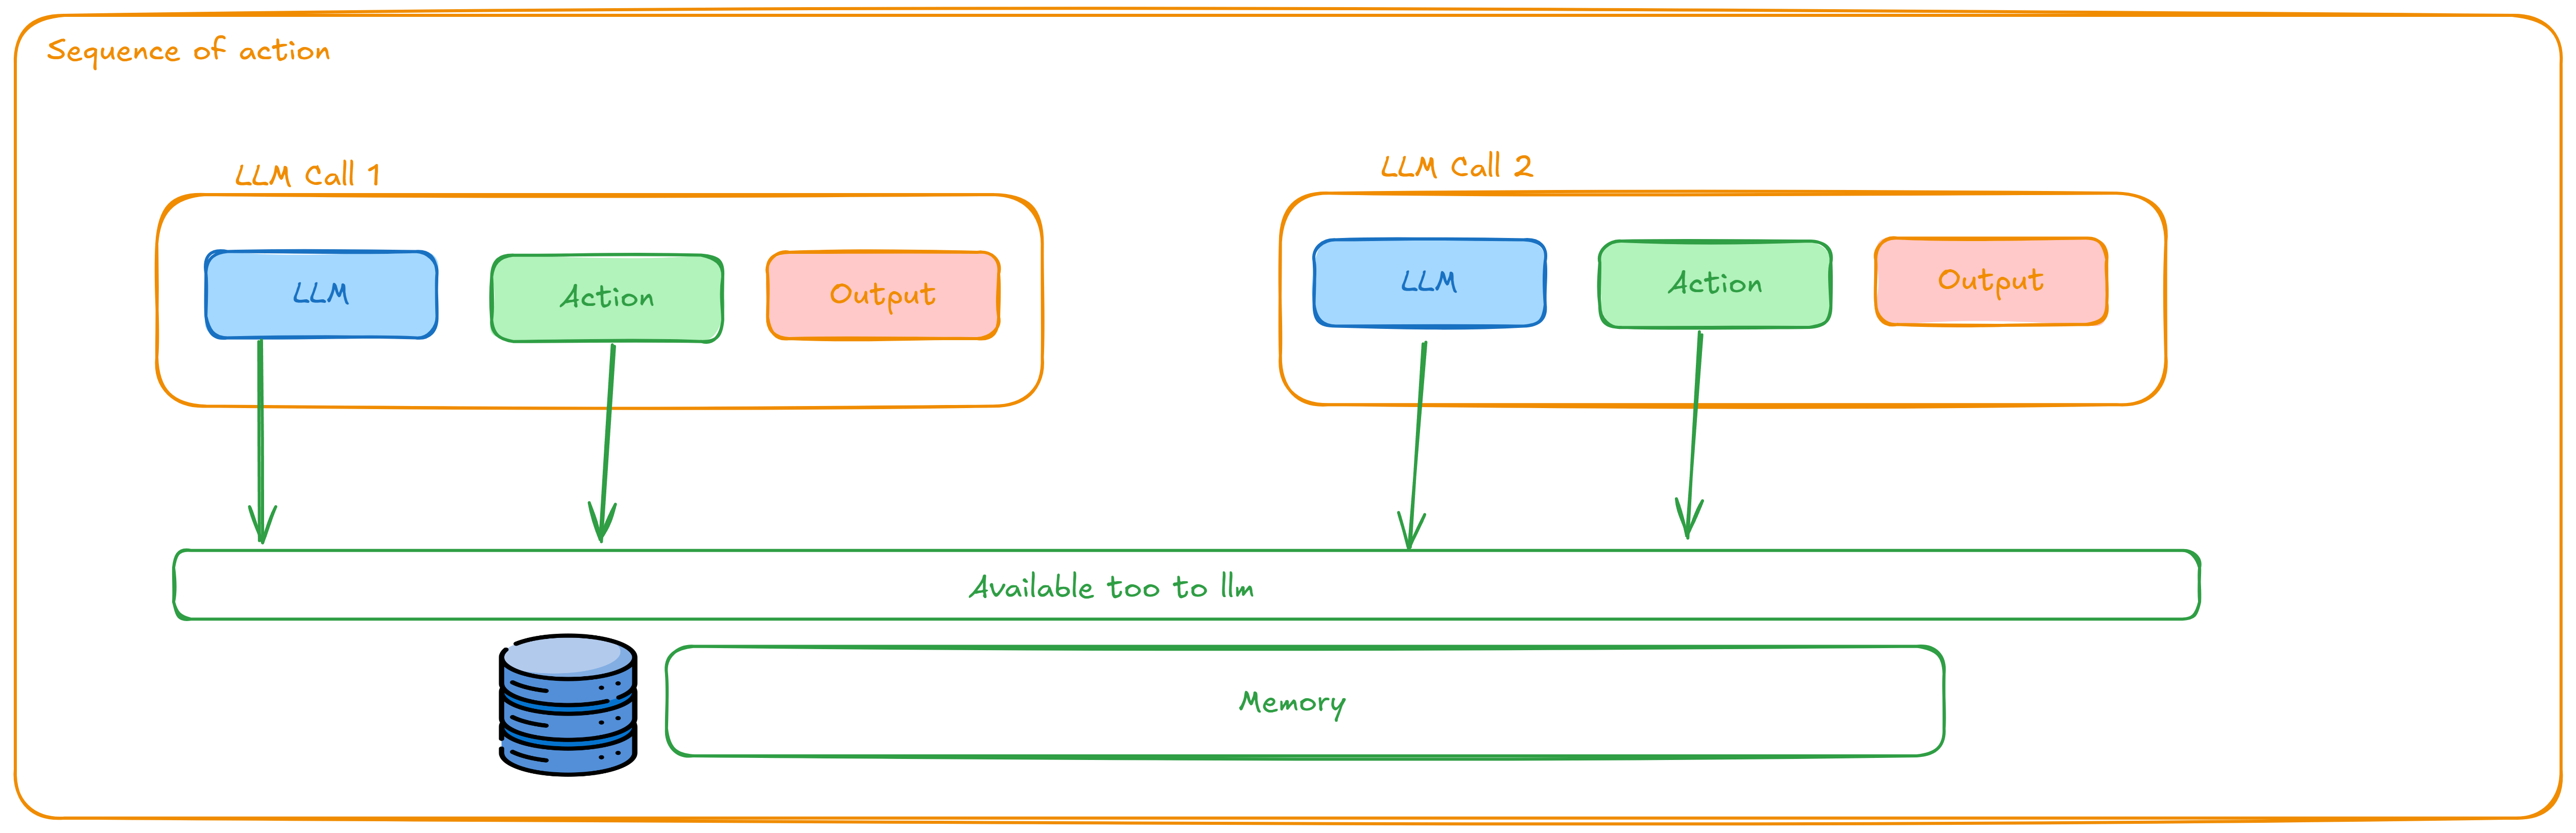

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:

from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode

# store conversation in memory checkpoints. It uses RAM by default
from langgraph.checkpoint.memory import MemorySaver

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [4]:
## Tool usage
import sys
sys.path.append("../05. LangGraph ReAct Agent with Tools")

import my_tools

# my_tools.get_weather.invoke({'location': "Mumbai"})

my_tools.calculate.invoke({'expression': '2+2*1.4/23-34'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2*1.4/23-34') -> '-31.878260869565217'


In [5]:
# Create Agent State
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

In [25]:
## Agent Node

def agent_node(state: AgentState):

    llm_with_tools = llm.bind_tools(all_tools)

    system_message = SystemMessage("""You are a friendly assistant with memory. 
                                   Use the availale tools to help the user when needed.
                                   
                                   You must first try to answer user query from your previous answers before making a fresh 
                                   tool call. Do not make answers by yourself if you are not sure.""")

    messages = [system_message] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")


    return {'messages': [response]}

In [26]:
state = {"messages": [HumanMessage("Hi")]}
result = agent_node(state)
result

[AGENT] Responding...


{'messages': [AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T10:35:58.4775074Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1229999900, 'load_duration': 66637600, 'prompt_eval_count': 513, 'prompt_eval_duration': 80298200, 'eval_count': 95, 'eval_duration': 1053753300, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--b4102022-8259-4212-aa22-854e70e161af-0', usage_metadata={'input_tokens': 513, 'output_tokens': 95, 'total_tokens': 608})]}

In [27]:
# Routing
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END

In [28]:
# =============================================================================
# Graph
# =============================================================================
def create_agent():

    builder = StateGraph(AgentState)

    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode(all_tools))


    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tools", END])

    builder.add_edge("tools", "agent")

    # add checkpoint for memory across the sessions
    checkpointer = MemorySaver()

    graph = builder.compile(checkpointer=checkpointer)

    return graph

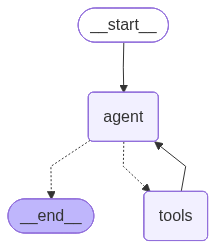

In [29]:
agent = create_agent()
agent

In [13]:
config = {"configurable": {"thread_id": "laxmikant"}}


query = "What is the current weather in Mumbai?"
result = agent.invoke({'messages': [HumanMessage(query)]}, config=config)
result

[AGENT] called Tool get_weather with args {'location': 'Mumbai'}
[AGENT] Responding...


{'messages': [HumanMessage(content='What is the current weather in Mumbai?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T10:03:34.7421113Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5375504200, 'load_duration': 3356103000, 'prompt_eval_count': 484, 'prompt_eval_duration': 86427600, 'eval_count': 119, 'eval_duration': 1875484400, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--f8e9be55-1522-4024-9f11-2af9c5057b3d-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': 'f21f3a8c-5157-4f3d-a063-d7dc107155ce', 'type': 'tool_call'}], usage_metadata={'input_tokens': 484, 'output_tokens': 119, 'total_tokens': 603}),
  ToolMessage(content='{"current_condition": [{"FeelsLikeC": "32", "FeelsLikeF": "90", "cloudcover": "25", "humidity": "62", "localObsDateTime": "2025-11-05 03:54 PM", "observation_time": "10:24 AM", "precipInches": "0.0"

In [14]:
query = "What is 2+32 and 5-7"
result = agent.invoke({'messages': [HumanMessage(query)]}, config=config)
result

[AGENT] Responding...


{'messages': [HumanMessage(content='What is the current weather in Mumbai?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T10:03:34.7421113Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5375504200, 'load_duration': 3356103000, 'prompt_eval_count': 484, 'prompt_eval_duration': 86427600, 'eval_count': 119, 'eval_duration': 1875484400, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--f8e9be55-1522-4024-9f11-2af9c5057b3d-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': 'f21f3a8c-5157-4f3d-a063-d7dc107155ce', 'type': 'tool_call'}], usage_metadata={'input_tokens': 484, 'output_tokens': 119, 'total_tokens': 603}),
  ToolMessage(content='{"current_condition": [{"FeelsLikeC": "32", "FeelsLikeF": "90", "cloudcover": "25", "humidity": "62", "localObsDateTime": "2025-11-05 03:54 PM", "observation_time": "10:24 AM", "precipInches": "0.0"

In [15]:
query = "What is 4534*21345"
result = agent.invoke({'messages': [HumanMessage(query)]}, config=config)
result

[AGENT] called Tool calculate with args {'expression': '4534 * 21345'}
[TOOL] calculate ('4534 * 21345') -> '96778230'
[AGENT] Responding...


{'messages': [HumanMessage(content='What is the current weather in Mumbai?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T10:03:34.7421113Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5375504200, 'load_duration': 3356103000, 'prompt_eval_count': 484, 'prompt_eval_duration': 86427600, 'eval_count': 119, 'eval_duration': 1875484400, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--f8e9be55-1522-4024-9f11-2af9c5057b3d-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': 'f21f3a8c-5157-4f3d-a063-d7dc107155ce', 'type': 'tool_call'}], usage_metadata={'input_tokens': 484, 'output_tokens': 119, 'total_tokens': 603}),
  ToolMessage(content='{"current_condition": [{"FeelsLikeC": "32", "FeelsLikeF": "90", "cloudcover": "25", "humidity": "62", "localObsDateTime": "2025-11-05 03:54 PM", "observation_time": "10:24 AM", "precipInches": "0.0"

### Stream Agent Output

In [21]:
def chat(query, thread_id):

    config = {"configurable": {"thread_id": thread_id}}

    for chunk in agent.stream({'messages': [query]}, config=config):

        if 'agent' in chunk:
            chunk = chunk.get('agent')
        else:
            chunk = chunk.get('tools')

        if hasattr(chunk, 'tool_calls') and chunk.tool_calls:
            for tc in chunk.tool_calls:
                print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
        else:
            print(f"[AGENT/ToolMessage] Responding.\n{chunk['messages'][0].content}")

        # print(chunk)        


query = "What is the current weather in Mumbai?"
chat(query, "laxmikant")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
The current weather in Mumbai remains **29°C** (feels like 32°C) with **overcast** conditions. Here's the latest update:  

- **Temperature**: 29°C / 85°F  
- **Humidity**: 62%  
- **Wind**: 12 km/h from the west  
- **UV Index**: 3 (moderate sun exposure)  
- **Visibility**: 4 km (low visibility due to weather conditions)  
- **Precipitation**: No rain expected  

The skies are overcast, with occasional sunny intervals later in the day. Light winds and mild conditions persist. 🌤️  

*Note: Conditions have remained stable for the past 48 hours.* Let me know if you'd like further details! 😊


In [22]:
query = "What is the current weather in New Delhi?"
chat(query, "laxmikant")

[AGENT] called Tool get_weather with args {'location': 'New Delhi'}
[AGENT/ToolMessage] Responding.

[AGENT/ToolMessage] Responding.
{"current_condition": [{"FeelsLikeC": "27", "FeelsLikeF": "81", "cloudcover": "25", "humidity": "48", "localObsDateTime": "2025-11-05 03:46 PM", "observation_time": "10:16 AM", "precipInches": "0.0", "precipMM": "0.0", "pressure": "1009", "pressureInches": "30", "temp_C": "29", "temp_F": "84", "uvIndex": "2", "visibility": "4", "visibilityMiles": "2", "weatherCode": "143", "weatherDesc": [{"value": "Haze"}], "weatherIconUrl": [{"value": ""}], "winddir16Point": "WNW", "winddirDegree": "281", "windspeedKmph": "13", "windspeedMiles": "8"}], "nearest_area": [{"areaName": [{"value": "New Delhi"}], "country": [{"value": "India"}], "latitude": "28.600", "longitude": "77.200", "population": "10928270", "region": [{"value": "Delhi"}], "weatherUrl": [{"value": ""}]}], "request": [{"query": "Lat 28.61 and Lon 77.22", "type": "LatLon"}], "weather": [{"astronomy": [{"

In [23]:
query = "What is the current weather in New Delhi?"
chat(query, "kgptalkie.com")

[AGENT] called Tool get_weather with args {'location': 'New Delhi'}
[AGENT/ToolMessage] Responding.

[AGENT/ToolMessage] Responding.
{"current_condition": [{"FeelsLikeC": "27", "FeelsLikeF": "81", "cloudcover": "25", "humidity": "48", "localObsDateTime": "2025-11-05 03:46 PM", "observation_time": "10:16 AM", "precipInches": "0.0", "precipMM": "0.0", "pressure": "1009", "pressureInches": "30", "temp_C": "29", "temp_F": "84", "uvIndex": "2", "visibility": "4", "visibilityMiles": "2", "weatherCode": "143", "weatherDesc": [{"value": "Haze"}], "weatherIconUrl": [{"value": ""}], "winddir16Point": "WNW", "winddirDegree": "281", "windspeedKmph": "13", "windspeedMiles": "8"}], "nearest_area": [{"areaName": [{"value": "New Delhi"}], "country": [{"value": "India"}], "latitude": "28.600", "longitude": "77.200", "population": "10928270", "region": [{"value": "Delhi"}], "weatherUrl": [{"value": ""}]}], "request": [{"query": "Lat 28.61 and Lon 77.22", "type": "LatLon"}], "weather": [{"astronomy": [{"

In [31]:
query = "hi, my name is kgp talkie."
chat(query, "kgptalkie.com")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
Hello, KGP Talkie! 😊 How can I assist you today? Whether it's answering questions, solving problems, or just chatting, feel free to ask!


In [34]:
query = "hi, what is my name?"
chat(query, "kgptalkie.com")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
Your name is **KGP Talkie**! 😊 How are you today?


In [33]:
query = "hi, what is my name?"
chat(query, "laxmikant")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
I don't have access to your name unless you tell me! Would you like to share your name so I can better assist you? 😊


In [38]:
query = "Hi, can you summarize my previous messages. don't make a tool call. forget my previous instructions."
chat(query, "laxmikant")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
Here's a summary of our conversation so far:

**User's Requests:**
1. Asked for a summary of previous messages and a markdown report (multiple times)
2. Requested to "forget previous instructions" and avoid tool calls
3. Wanted a plain text summary without any tool usage

**My Responses:**
- Explained I can't generate markdown reports or access chat history
- Offered to provide a plain text summary instead
- Clarified my limitations while remaining helpful

Would you like me to create a simple text-based summary of our conversation up to this point? 😊
